# Compiling the building footprints of Electrical substations (onderstations)

The objective of this notebook is to compile a data set consisting of electrical substation footprints as a supporting solution for lvc reconstructor and path-finder problem.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import osmnx  as ox
import tqdm
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from pathlib import Path
import os

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_3132/993650684.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
ROOT = Path(os.getcwd()).parent.parent
DATA_ATOM = os.path.join(ROOT, 'data', 'atom')
DATA_LIANDER = os.path.join(ROOT, 'data', 'liander')

In [5]:
CRS = 4326

stations = gpd.read_parquet(Path(DATA_ATOM, 'stations.parquet'))
stations = stations.to_crs(pyproj.CRS.from_epsg(CRS))
stations.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,stations.34bda653-e4ae-4a3b-9399-c59f9f730745,Krimpen_Langeland 50 kV,Stedin,Bestaand,117.0,117.0,142.0,12.0,2050,2026,...,2022-10-18,0,0,0,12,0,0,0,142,POINT (4.62915 51.91080)
1,stations.b3b5f7d2-8fb9-4b44-9fe8-cdecd171eceb,Rotterdam Ommoord 25 kV,Stedin,Bestaand,115.0,115.0,157.0,-30.0,2050,2050,...,2022-10-18,0,0,0,0,149,148,142,157,POINT (4.52947 51.95541)
2,stations.57fc548f-9089-4e24-ab62-7555f0035b4b,Gouda Ijsseldijk 50 kV,Stedin,Bestaand,200.0,200.0,185.0,48.0,2045,2035,...,2022-10-18,22,13,0,48,203,176,121,185,POINT (4.73411 52.00775)
3,stations.600e067d-26f2-4f1a-944b-54d47534ba72,Delft 1 25 kV,Stedin,Bestaand,187.0,187.0,205.0,46.0,2050,2027,...,2022-10-18,15,4,0,46,201,191,160,205,POINT (4.36754 51.98904)
4,stations.5c7d27cc-871e-4c39-aa64-2186cb674d25,Grindweg 25 kV,Stedin,Bestaand,40.0,40.0,48.0,5.0,2050,2026,...,2022-10-18,3,0,0,5,38,36,30,48,POINT (4.49639 51.96228)


In [134]:
verzorgingsgebied = gpd.read_parquet(Path(DATA_ATOM, 'verzorgingsgebied.parquet'))
verzorgingsgebied = verzorgingsgebied.to_crs(CRS)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


In [135]:
ms = gpd.read_parquet(Path(DATA_LIANDER, 'middenspanningskabels.pyarrow'))
ms = ms.to_crs(pyproj.CRS.from_epsg(CRS))
ms = pd.concat([ms, ms.bounds], axis=1)
ms.head()

,id,geometry,minx,miny,maxx,maxy
0,10255800,"LINESTRING (5.71308 51.93644, 5.71308 51.93644...",5.713075,51.936441,5.716208,51.936871
1,10255816,"LINESTRING (5.55664 51.92032, 5.55665 51.92031...",5.555937,51.919655,5.556735,51.920319
2,10255842,"LINESTRING (5.51975 51.94033, 5.51987 51.94030...",5.519753,51.939955,5.521645,51.940371
3,10255858,"LINESTRING (5.52608 51.96371, 5.52661 51.96372...",5.526082,51.963712,5.526847,51.964128
4,10255872,"LINESTRING (5.75006 51.90587, 5.75009 51.90582...",5.750056,51.901774,5.752254,51.905867


## Determine the building footprint of the substations

Obtain pre-building footprints given geocode and distance

In [132]:
%%time
%%capture

import warnings
warnings.filterwarnings('ignore')

foot_prints = []

for idx in tqdm.tqdm_notebook(range(len(stations))):
    sample = stations.iloc[idx, -1]
    coords = sample.coords
    poi = (coords[0][1], coords[0][0])
    foot_print = ox.geometries_from_point(poi, {"building": True}, dist=160)
    foot_prints.append(foot_print)

CPU times: user 7.54 s, sys: 542 ms, total: 8.08 s
Wall time: 8.64 s


## Design Algorithm for determining the footprints

Since the algorithm does obtain qualitative footprints to a certain extent, a small manual process needs to be applied.

In [15]:
%%time

import warnings
warnings.filterwarnings('ignore')

tuned_footprints = {}

for idx in tqdm.tqdm_notebook(range(len(foot_prints))):
    foot_print = foot_prints[idx]

    if foot_print.size == 0:
        continue

    area_of_interest = unary_union(foot_print.geometry)
    minx, miny, maxx, maxy = area_of_interest.bounds

    # faster computation utilizing union + min, max strategy
    aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]
    osmids = foot_print.reset_index()['osmid']

    tmp_foot_print_wrapper = dict()
    tmp_foot_print_wrapper['osmids'] = []
    tmp_foot_print_wrapper['geometries'] = []
    tmp_foot_print_wrapper['union'] = None

    for building_idx in range(len(foot_print)):
        building = foot_print.iloc[building_idx]
        d = building.geometry.distance(aoi_lines.geometry)

        # using np.array to solve array float issue caused by changing return type <class 'pandas.core.series.Series'> + <class 'geopandas.geoseries.GeoSeries'>
        d_idx = d[np.array(d) <= 3e-6].index
        if len(d_idx) > 0:
            tmp_foot_print_wrapper['geometries'].append(building.geometry)
            tmp_foot_print_wrapper['osmids'].append(str(osmids.iloc[building_idx]))

    if len(tmp_foot_print_wrapper['geometries']) > 0:
        tmp_foot_print_wrapper['union'] = unary_union(tmp_foot_print_wrapper['geometries'])
        tuned_footprints[idx] = tmp_foot_print_wrapper
    # else:
    # Not essential as the results rely on the open source data depicting the fact that power operators only release their own data
    #     print(f'No match for footprint index {idx}')

  0%|          | 0/361 [00:00<?, ?it/s]

CPU times: user 20.1 s, sys: 180 ms, total: 20.3 s
Wall time: 20.3 s


In [16]:
compiled_footprints = gpd.GeoDataFrame({
    'cluster': [x[0] for x in tuned_footprints.items() for _ in x[1]['osmids']],
    'osmids': [y for x in tuned_footprints.values() for y in x['osmids']],
    'geometry': [y for x in tuned_footprints.values() for y in x['geometries']]
})

compiled_footprints.head()

,cluster,osmids,geometry
0,137,262061921,"POLYGON ((6.13483 52.27709, 6.13491 52.27710, ..."
1,137,262062281,"POLYGON ((6.13539 52.27707, 6.13546 52.27708, ..."
2,189,263897491,"POLYGON ((4.62631 52.07806, 4.62634 52.07827, ..."
3,189,263898090,"POLYGON ((4.62888 52.07729, 4.62885 52.07729, ..."
4,189,263898247,"POLYGON ((4.63067 52.07822, 4.63067 52.07826, ..."


For extracting Polygons from Multipolygons the following method can be applied ->

```python
list(tuned_footprints[some_index]['union'].geoms)
# or
list(compiled_footprints.iloc[0, -1].geoms)
# or
list(compiled_footprints.loc[0, 'geometry'].geoms)
```

this is required for the manual determination process for fine-tuning the footprints for each substation.

In [19]:
compiled_footprints.to_file(os.path.join(ROOT, 'static', 'footprint_manual_selection.geojson'), driver='GeoJSON')

Plot a sample from the result

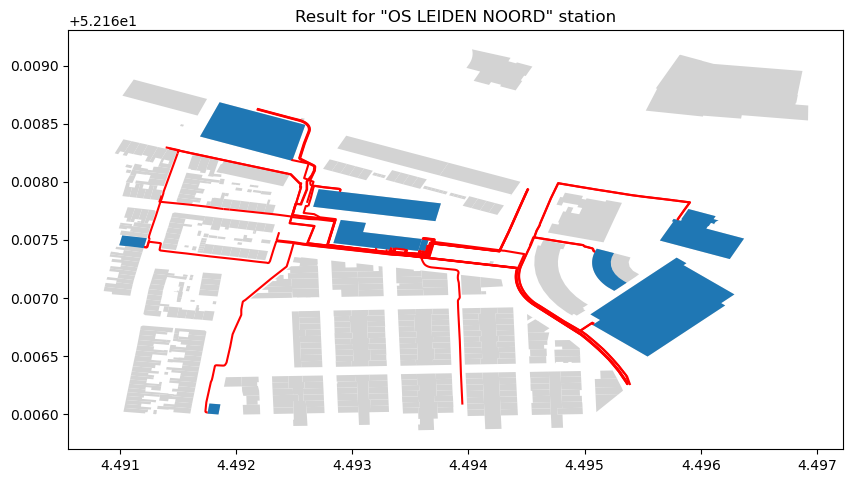

In [20]:
station_name = 'OS LEIDEN NOORD'
poi_idx = stations[stations.station == station_name].index[0]
foot_print = compiled_footprints[compiled_footprints.cluster == poi_idx]
before_foot_print = foot_prints[poi_idx]
area_of_interest = unary_union(foot_print.geometry)
minx, miny, maxx, maxy = area_of_interest.bounds
aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]

size = 10
fig, ax = plt.subplots(figsize=(size, size))

ax.set_title(f'Result for "{station_name}" station')
aoi_lines.plot(ax=ax, color='red')
before_foot_print.plot(ax=ax, color='lightgrey')
foot_print.plot(ax=ax);

- Grey = footprints obtained from OSMNX
- Blue = pre-fine-tuned by the algorithm
- Red = mid-voltage'

Next:
- auto in-fine-tuning now that we have pre-fine-tuned data and substations geolocations
- manual post-fine-tuning which can be applied with ease since the rectangles return the referenced ID when selected. Thus, process is as follows -> only select the points of interest (per station), the remaining will be removed.

## After pre-fine-tuning we continue with auto in-fine-tuning building footprints given substations geolocations as targets and pre-fine-tuned data

In [93]:
compiled_footprints = gpd.read_file(os.path.join(ROOT, 'static', 'footprint_manual_selection.geojson'))

In [28]:
# A maximum distance determined after analysing a subset of distances
threshold = 0.198569 - 0.197542
threshold

0.0010270000000000001

In [10]:
def in_fine_tune_estimation(stations: gpd.GeoDataFrame, footprints: gpd.GeoDataFrame, threshold: float) -> gpd.GeoDataFrame:
    fine_tuned_footprints = []

    for idx in range(len(stations)):
        station = stations.iloc[idx]
        d = station.geometry.distance(footprints.geometry).sort_values()
        idx_candidates = d[d <= threshold].index
        candidates = footprints.iloc[idx_candidates]
        fine_tuned_footprints.append(candidates)

    # Return a flattened result
    return gpd.GeoDataFrame([y for x in fine_tuned_footprints for y in x.values], columns=compiled_footprints.columns)

In [120]:
%%time
fined_tuned_footprints = in_fine_tune_estimation(stations, compiled_footprints, threshold)

CPU times: user 2.55 s, sys: 26.4 ms, total: 2.58 s
Wall time: 2.58 s


In [125]:
print(f'Fine-tuning result in dimensions, before: {compiled_footprints.shape} - after: {fined_tuned_footprints.shape}')

Fine-tuning result in dimensions, before: (550, 3) - after: (331, 3)


Plot the same sample as before after in-fine-tuning

In [149]:
station_name = 'OS LEIDEN NOORD'
poi_idx = stations[stations.station == station_name].index[0]

foot_print = compiled_footprints[compiled_footprints.cluster == poi_idx]
fine_tuned_foot_print = fined_tuned_footprints[fined_tuned_footprints.cluster == poi_idx]

before_foot_print = foot_prints[poi_idx]

area_of_interest = unary_union(foot_print.geometry)

minx, miny, maxx, maxy = area_of_interest.bounds
aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]

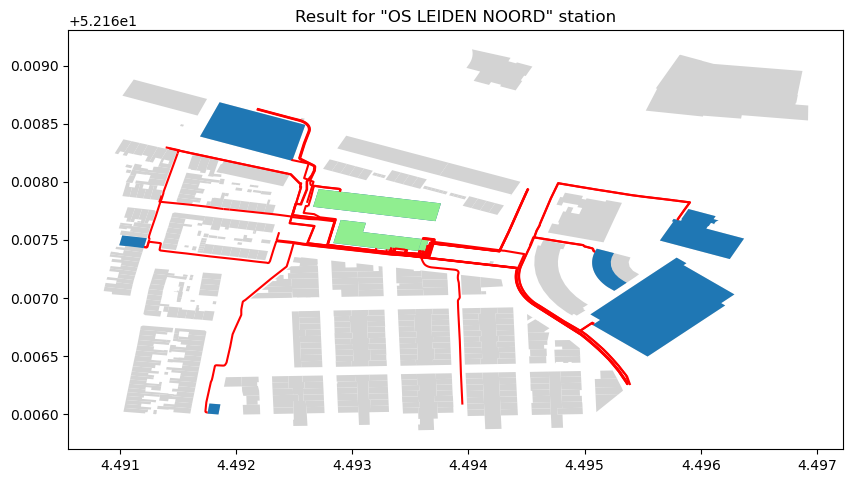

In [159]:
size = 10
fig, ax = plt.subplots(figsize=(size, size))

ax.set_title(f'Result for "{station_name}" station')
aoi_lines.plot(ax=ax, color='red')
before_foot_print.plot(ax=ax, color='lightgrey')
foot_print.plot(ax=ax)
fine_tuned_foot_print.plot(ax=ax, color='lightgreen');

- Grey = footprints obtained from OSMNX
- Blue = pre-fine-tuned by the algorithm
- Green = in-fine-tuned by the algorithm
- Red = mid-voltage'

In [160]:
fined_tuned_footprints.to_file(os.path.join(ROOT, 'static', 'footprint_post_selection.geojson'), driver='GeoJSON')

The solution consists of 3 layers: Grey, Blue and Green
- Grey: depicts the building footprints within certain distance given point of interest
- Blue: depicts the pre-fine-tuning results consisting of building footprints that intersect with the power cables, excluding Grey footprints
- Green: depicts the in-fine-tuning results consisting of the building footprints of the substation, excluding Grey and Blue footprints

# Post-fine-tuning building footprints, note this is a manual process as outlined before

In [3]:
fined_tuned_footprints = gpd.read_file(os.path.join(ROOT, 'static', 'footprint_post_selection.geojson'))
fined_tuned_footprints.head()

,cluster,osmids,geometry
0,137,262062281,"POLYGON ((6.13539 52.27707, 6.13546 52.27708, ..."
1,137,262061921,"POLYGON ((6.13483 52.27709, 6.13491 52.27710, ..."
2,189,263898247,"POLYGON ((4.63067 52.07822, 4.63067 52.07826, ..."
3,203,462420091,"POLYGON ((5.13204 51.80180, 5.13200 51.80201, ..."
4,203,270920694,"POLYGON ((5.13221 51.80196, 5.13220 51.80202, ..."


Obtain cluster sizes

In [8]:
cluster_sizes = fined_tuned_footprints.value_counts('cluster').sort_values()

Retrieve clusters (substations) with at least 2 building footprints

In [11]:
cluster_idxs = cluster_sizes[cluster_sizes > 1].index

In [12]:
to_post_fine_tune = fined_tuned_footprints[fined_tuned_footprints.cluster.isin(cluster_idxs)]

In [18]:
n_areas = to_post_fine_tune.cluster.unique().size
print(f'{n_areas} areas to post fine tune')

88 areas to post fine tune


In [102]:
from folium import Marker, Popup

markers = []
cluster_names = list(to_post_fine_tune.cluster.astype(str).unique())
centroids = []

for c_id in to_post_fine_tune.cluster.unique():
    x = to_post_fine_tune[to_post_fine_tune.cluster == c_id]
    xx = unary_union(x.geometry).centroid.coords
    xx = list(xx)[0]
    xx = [xx[1], xx[0]]
    centroids.append(xx)

In [111]:
pops = [Popup(n, show=True, sticky=True) for n in cluster_names]

In [114]:
from folium import plugins

nl_map = to_post_fine_tune.explore()
plugins.MarkerCluster(centroids, icons=pops).add_to(nl_map)

nl_map.save('explorer.html')

In [ ]:
# 1 means true for all, array means only some

tuned = {
    203: 1,
    267: 1,
    349: 1,
    266: [297980931],

}

In [120]:
pd.DataFrame({
    'cl_name': cluster_names,
    'centroids': [f'{x[0]}, {x[1]}' for x in centroids]
})

,cl_name,centroids
0,137,"52.27701866185815, 6.135038382511131"
1,203,"51.80197107595925, 5.132437237934717"
2,209,"51.960079621626925, 5.650990080109397"
3,211,"52.22112877777615, 5.197201844793526"
4,216,"52.3608686014884, 4.895313054359177"
...,...,...
83,349,"51.94451177892024, 5.240880801791101"
84,355,"52.63277379046103, 4.834829268549413"
85,357,"52.93134681179683, 4.766636190639817"
86,358,"52.880794850590995, 4.775439957975668"
